# Eveluation on the test set
We choose the integration of SVC model built by the traning and dev sets based on the optimal settings (roll_svc_model_20210621.joblib) and post-process (smoothing in 75 window size) as our final classifier. Then we apply it on the test set to describe it's performance. Remeber, the discussion can only be made on the dev set's performance.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib as mpl
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

## Read predictions
The predictions were made through SVC_smooth_test.py.

In [2]:
y_df = pd.read_csv('results/roll_test_y_20210621.csv', index_col=0)
y_df.head()

,y,y_svc_s,core_section
composite_id,,,
N12_01857,1,2,N12-2
N12_01859,1,2,N12-2
N12_01861,1,2,N12-2
N12_01863,1,2,N12-2
N12_01865,1,2,N12-2


In [3]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

In [4]:
def plot_recall(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test)
    """
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import balanced_accuracy_score as score

    for col in y_preds:
        # make confusion matrix between prediction and actual labels
        confusion = confusion_matrix(data_df.y, data_df[col])
        model_name = col[2:]
        con_df = pd.DataFrame(confusion, index = Facies, columns = Facies)
        #con_df.to_csv('results/roll_confusion_{}_{}.csv'.format(model_name, date))

        # normalize the counts ineach row and present in percent
        x = np.copy(confusion).astype(float)
        x /= x.sum(axis = 1, keepdims = True)
        con_per = pd.DataFrame((x*100).astype(int), index = Facies, columns = Facies)
        #con_per.to_csv('results/roll_recall_%_{}_{}.csv'.format(model_name, date))

        # Plot the matrix
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(con_per, annot = con_per.astype(str), ax = ax, cmap = 'GnBu', square = True, vmin=0, vmax=100,
                    xticklabels = con_per.index, yticklabels = con_per.columns, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Data percentage in each row'}
                   )

        ax.set_xlabel('Prediction (accuracy: {:.2f})'.format(score(y_true=data_df.y, y_pred=data_df[col])), size = 14)
        ax.set_ylabel('Actual facies', size = 14)
        fig.savefig('results/roll_{}_recall_%_{}_{}.png'.format(split, model_name, date))

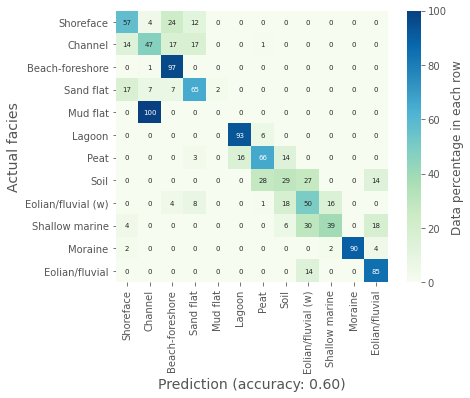

In [5]:
plot_recall(y_df, ['y_svc_s'], Facies, 'test')

In [6]:
def detect_conjuction(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test).
    """
    
    data_df['id'] = range(len(data_df))
    mat_dict = {}


    for y_pred in y_preds:
        y_mean = []
        composite_id = []
        model_name = y_pred[2:] if len(y_pred)>1 else 'description'
        
        for section in np.unique(data_df.core_section):
            y_mean = np.hstack((y_mean, data_df.loc[data_df.core_section == section, y_pred].rolling(window = 2).mean()))
            composite_id = np.hstack((composite_id, data_df[data_df.core_section == section].index))

        # merge the rolling with the original label
        # this will lost the first data poit in each section, but it doesn't mater
        # because the boundary shouldn't be at the begining of each section
        tmp_df = pd.concat([data_df, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna()], join = 'inner', axis = 1)

        # if y_pred is not same as y_mean, it means there is a boundary (facies change) between this and above depth
        bd_df = tmp_df[tmp_df[y_pred] != tmp_df.y_mean].copy()
        bd_df['ab_id'] = bd_df.id - 1
        if len(model_name) > 6:
            print('There are {} boundaries in description.'.format(len(bd_df)))
        else:
            print('There are {} boundaries in the optimized {} model\'s predictions.'.format(len(bd_df), model_name))

        # build matrix of boundaries
        bd_mat = np.zeros(shape = (12, 12), dtype = int)

        for row in bd_df.iterrows():
            tmp = np.zeros(shape = (12, 12), dtype = int)
            tmp[data_df[y_pred][int(row[1].ab_id)], data_df[y_pred][int(row[1].id)]] = 1
            bd_mat += tmp
            
        mat_dict[y_pred] = bd_mat
        
        # plot
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                    xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
                   )
        ax.set_xlabel('Below facies', size = 16)
        ax.set_ylabel('Above facies', size = 16)
        fig.savefig('results/roll_{}_conjunction_matrix_{}_{}.png'.format(split, model_name, date))
    
    return mat_dict

There are 29 boundaries in description.
There are 204 boundaries in the optimized svc_s model's predictions.


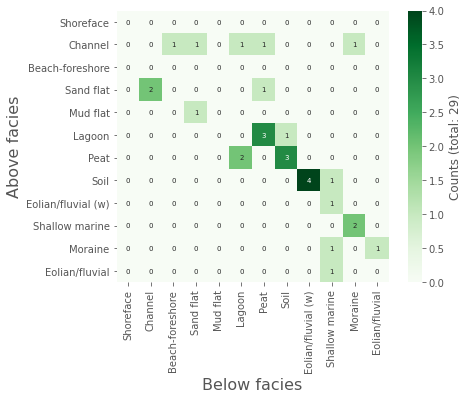

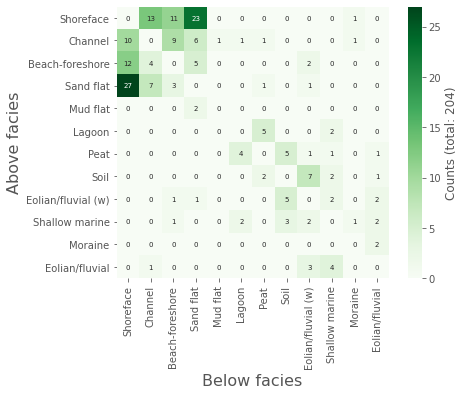

In [7]:
mat_dict = detect_conjuction(y_df,  ['y', 'y_svc_s'], Facies, 'test')

# The result after integrated with sophisticate smoothing
The result is produced by SVC_smooth_test.py.

In [2]:
y_df = pd.read_csv('results/roll_post_y_test_20210723.csv', index_col=0)
y_df

,0,1,2,3,4,5,6,7,8,9,10,11,y,y_pred,y_pred_s,core_section,y_smooth
N12_01857,9.317170,10.321750,11.319483,8.316805,4.702558,0.692474,5.816535,2.692942,3.689356,4.709570,2.712498,0.677494,1,2,2,N12-2,1
N12_01859,9.317379,10.321896,11.319591,8.316661,5.705908,1.694155,5.843404,2.693410,3.688358,4.710015,1.706676,-0.322893,1,2,2,N12-2,1
N12_01861,9.318011,10.322028,11.319772,8.317033,5.706912,1.694143,5.835742,2.692696,3.688312,4.707545,1.706240,-0.323263,1,2,2,N12-2,1
N12_01863,9.317796,10.321947,11.319917,8.317054,5.704680,1.693686,5.832382,2.692425,3.687997,4.707037,1.709563,-0.323026,1,2,2,N12-2,1
N12_01865,9.317571,10.321518,11.319450,8.316661,4.699670,-0.308083,6.808881,2.692275,3.690052,4.709760,2.719239,0.677642,1,2,2,N12-2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_02133,5.129889,8.326601,5.799333,6.315859,5.041743,10.303707,11.324552,8.310654,0.673954,4.311682,0.672969,0.673988,6,6,6,W5-1,6
W5_02135,5.242592,8.326913,5.918805,6.316680,5.059648,10.306797,11.324515,8.305979,0.673404,4.312105,0.672947,0.673727,6,6,6,W5-1,6
W5_02137,5.169696,8.327102,6.241166,6.318170,5.022736,10.308658,11.324750,8.307745,0.673115,4.309203,0.672728,0.673511,6,6,6,W5-1,6
W5_02139,5.160012,8.327573,6.270550,6.320030,3.727052,10.310853,11.325070,8.307673,1.672994,5.309889,0.672348,-0.326881,6,6,6,W5-1,6


In [3]:
from sklearn.metrics import balanced_accuracy_score as score
from post_process import count_boundary

print('Balanced score of the prediction: {:.2f}'.format(score(y_true=y_df.y, y_pred=y_df.y_pred)))
print('Balanced score after simple smoothing: {:.2f}'.format(score(y_true=y_df.y, y_pred=y_df.y_pred_s)))
print('Balanced score after sophisticate smoothing: {:.2f}'.format(score(y_true=y_df.y, y_pred=y_df.y_smooth)))

print('Boundary amount of the prediction: {}'.format(count_boundary(y_df.y_pred, y_df.core_section)))
print('Boundary amount after simple smoothing: {}'.format(count_boundary(y_df.y_pred_s, y_df.core_section)))
print('Boundary amount after sophisticate smoothing: {}'.format(count_boundary(y_df.y_smooth, y_df.core_section)))
print('Boundary amount of description: {}'.format(count_boundary(y_df.y, y_df.core_section)))

Balanced score of the prediction: 0.58
Balanced score after simple smoothing: 0.58
Balanced score after sophisticate smoothing: 0.56
Boundary amount of the prediction: 1236
Boundary amount after simple smoothing: 382
Boundary amount after sophisticate smoothing: 264
Boundary amount of description: 29
